<a href="https://colab.research.google.com/github/mykon23/AI-2020/blob/master/Activities/Activity11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Overfitting vs Generalization: MLB Playoff Teams

In [1]:
!wget -O Baseball.csv https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True

--2020-09-26 05:14:21--  https://github.com/mykon23/AI-2020/blob/master/Data/Baseball.csv?raw=True
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv [following]
--2020-09-26 05:14:21--  https://github.com/mykon23/AI-2020/raw/master/Data/Baseball.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv [following]
--2020-09-26 05:14:21--  https://raw.githubusercontent.com/mykon23/AI-2020/master/Data/Baseball.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 20

##Binary Classification of whether an MLB Enters Playoffs (Wildcard Era)

In [2]:
import pandas as pd
data = pd.read_csv('Baseball.csv')
data.head()

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
0,ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NaN,NaN,162,0.317,0.415
1,ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4.0,5.0,162,0.306,0.378
2,BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5.0,4.0,162,0.315,0.403
3,BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NaN,NaN,162,0.331,0.428
4,CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NaN,NaN,162,0.335,0.424


Get the Data of Interest

In [3]:
##Get the features of interest
features = [ 'RS', 'RA', 'W', 'OBP', 'SLG', 'BA' ]

##Binary classiciation to determine if playoff team
output = [ 'Playoffs' ]

##Only get data from wildcard era introduced in 1994.  8+ teams enter
work_data = data[ data['Year'] > 1994 ]
work_data = work_data[ ['Year'] + features + output ]
work_data.head()

,Year,RS,RA,W,OBP,SLG,BA,Playoffs
0,2012,734,688,81,0.328,0.418,0.259,0
1,2012,700,600,94,0.320,0.389,0.247,1
2,2012,712,705,93,0.311,0.417,0.247,1
3,2012,734,806,69,0.315,0.415,0.260,0
4,2012,613,759,61,0.302,0.378,0.240,0


Split the Data into Training Data and Validation Data

In [4]:
import numpy as np

##Validation set will be split according to random years.  No shuffling of data.
years = work_data['Year'].unique()
val_years = np.random.choice( years, int(0.25 * len(years)), replace=False )
print(val_years)

[2011 1996 2003 2004]


In [5]:
##Establish the Training Set and the Validation Sets

TRAIN = pd.DataFrame()
VALID = pd.DataFrame()

for y in years:
  elem = work_data[ work_data['Year'] == y ][ features + output ]
  if y in val_years:
    VALID = pd.concat( [VALID, elem] )
  else:
    TRAIN = pd.concat( [TRAIN, elem] )

##Training Set
TRAIN = TRAIN.to_numpy()
XTRAIN = TRAIN[:, :-1]
YTRAIN = TRAIN[:, -1]

##Valdiation Set
VALID = VALID.to_numpy()
XVALID = VALID[:, :-1]
YVALID = VALID[:, -1]

In [6]:
##Get Baseline Accuracy
baseline = { 'train': YTRAIN.sum()/len(YTRAIN), 'val': YVALID.sum()/len(YVALID) }

print('Basline Accuracy')
for k in baseline:
  print(f'{k:8s} {baseline[k]:2f}')

Basline Accuracy
train    0.273196
val      0.271186


Apply Standardization to Data Sets



In [7]:
##Adjust the training data
mean = XTRAIN.mean(axis = 0)
XTRAIN -= mean
std = XTRAIN.std(axis = 0)
XTRAIN /= std

##Adjust the validation data
XVALID -= mean
XVALID /= std

##Build the Overfitting Neural Network

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add( Dense(18, input_dim = len(XTRAIN[0]), activation='relu') )
model.add( Dense(6, activation='relu' ))
model.add( Dense(3, activation='relu' ))
model.add( Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                126       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 114       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


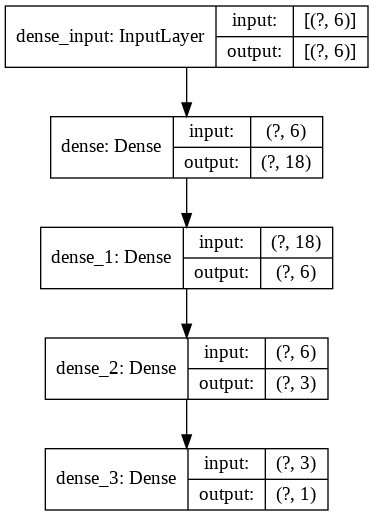

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names = True, show_shapes = True)

Train and Evaluate on the Training Data

In [10]:
##Train the model
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
model.fit(XTRAIN, YTRAIN, epochs = 1024, verbose = 0)

##Evaluate the training set accuracy
train_acc = model.evaluate(XTRAIN, YTRAIN)

13/13 [==============================] - 0s 1ms/step - loss: 0.0257 - accuracy: 0.9948


Evaluate on the Validation Set

In [11]:
##Evaluate the validation Set
val_acc = model.evaluate(XVALID, YVALID)

4/4 [==============================] - 0s 2ms/step - loss: 1.0192 - accuracy: 0.8559


The model is more accurate on the training set than on the validation set.  The loss on the validation set is much greater than the loss on the training set.

##Evaluate Model Performance Metrics

In [12]:
##Get the predictions the model makes for each data set
PTRAIN = model.predict(XTRAIN)
PVALID = model.predict(XVALID)

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

##Functionto return metrics of interest for evaluation
def get_metrics(y, pred):
  return { 'accuracy': accuracy_score(y, pred.round()),
          'precision': precision_score(y, pred.round()),
          'recall': recall_score(y, pred.round()) }

train_metrics = get_metrics(YTRAIN, PTRAIN)
valid_metrics = get_metrics(YVALID, PVALID)


In [14]:
print(f'{"Metric":10s} {"Train":8s} {"Val":8s}')
for k in sorted(train_metrics.keys()):
  print(f'{k:10s} {train_metrics[k]:2f} {valid_metrics[k]:2f}')

Metric     Train    Val     
accuracy   0.994845 0.855932
precision  0.981481 0.727273
recall     1.000000 0.750000


The overfitted model performs better on the training set than the validation set in terms of accuracy, precision, and recall.  The accuracy measurement is respectable on the validation though the loss is significantly greater on the validation set than on the training set.  The observed deviation in performance is a result of the model overtraining on the training data and failing to generalize.  Training a model with a simpler architecture can mitigate the problem of overtraining as its trainable parameters will generalize the data to yield a comparable performance between the training and validation sets.

Overtraining can be a problem because it does not yield a model that generalizes the data.  The objective of training a model is to yield a model capable of generalizing the data to yield approximate predictions for known and unkown records.

Generalization is the model's ability to acquire accurate predictions on unknown data based on the information that the model has learned.  Overfitting is the occurance in which a model memorizes patterns within the training data that the model performs well on the training data and fails to generalize.  The model memorizes data within the training set such that the model fails to yield accurate predictions on data it has not encountered.  Overfitting may occur from an overly complicated architecture that permits the memorization of the training data or performing excessive training iterations.  Underfitting occurs when the model performs poorly on both the training set and any other test sets: validation or test sets.  Underfitting may be a result of insufficient training epochs or the model having too simple of an architecture to learn meaningful data from the training data.

The validation set must be normalized according to the parameters acquired from the training set due both sets of data originating from the same distribution.  IID is requirement for machine learning to be feasible.  The training set contains more information that yields more accurate information about the distribution than is available in the validation set.  The mean and standard deviation may differ in the validation set due to insufficient data given that the majority of the data is reserved for the training set.